Follow along at https://tinyurl.com/BraindecodeBCI101

In [ ]:
! pip install --upgrade braindecode
! git clone https://github.com/NeuroTechX/moabb.git
! pip install -r moabb/requirements.txt
! pip install moabb/
! rm -r moabb/

# Braindecode Tutorial

Main documentation at https://braindecode.org

## Loading and preprocessing the dataset

### Loading

First, we load the data. In this tutorial, we use the functionality of braindecode to load datasets through [MOABB](https://github.com/NeuroTechX/moabb) to load the BCI Competition IV 2a data.


> **Note:** To load your own datasets either via mne or from preprocessed X/y numpy arrays, see [MNE Dataset Tutorial](./https://braindecode.org/auto_examples/plot_mne_dataset_example.html) and [Numpy Dataset Tutorial](https://braindecode.org/auto_examples/plot_custom_dataset_example.html).
    

In [ ]:
from braindecode.datasets.moabb import MOABBDataset
import mne
mne.set_log_level('error')

subject_id = 3 # a nice subject! :)
dataset = MOABBDataset(dataset_name="BNCI2014001", subject_ids=[subject_id])

/usr/local/lib/python3.6/dist-packages/moabb/datasets/bnci.py:535: DeprecationWarning: Passing montage to create_info is deprecated and will be removed in 0.21, use raw.set_montage (or epochs.set_montage, etc.) instead
  ch_names=ch_names, ch_types=ch_types, sfreq=sfreq, montage=montage)
/usr/local/lib/python3.6/dist-packages/moabb/datasets/bnci.py:535: DeprecationWarning: Passing montage to create_info is deprecated and will be removed in 0.21, use raw.set_montage (or epochs.set_montage, etc.) instead
  ch_names=ch_names, ch_types=ch_types, sfreq=sfreq, montage=montage)
/usr/local/lib/python3.6/dist-packages/moabb/datasets/bnci.py:535: DeprecationWarning: Passing montage to create_info is deprecated and will be removed in 0.21, use raw.set_montage (or epochs.set_montage, etc.) instead
  ch_names=ch_names, ch_types=ch_types, sfreq=sfreq, montage=montage)
/usr/local/lib/python3.6/dist-packages/moabb/datasets/bnci.py:535: DeprecationWarning: Passing montage to create_info is deprecated a

In [ ]:
dataset.description

,subject,session,run
0,3,session_T,run_0
1,3,session_T,run_1
2,3,session_T,run_2
3,3,session_T,run_3
4,3,session_T,run_4
5,3,session_T,run_5
6,3,session_E,run_0
7,3,session_E,run_1
8,3,session_E,run_2
9,3,session_E,run_3


### Preprocessing

Now we apply preprocessing like bandpass filtering to our dataset.
You can either apply functions provided by [mne.Raw](https://mne.tools/stable/generated/mne.io.Raw.html) or [mne.Epochs](https://mne.tools/0.11/generated/mne.Epochs.html#mne.Epochs) or apply your own functions, either to the MNE object or the underlying numpy array.

> **Note:** These prepocessings are now directly applied to the loaded data, and not on-the-fly applied as transformations in PyTorch-libraries like [torchvision](https://pytorch.org/docs/stable/torchvision/index.html).


In [ ]:
from braindecode.datautil.preprocess import exponential_moving_standardize
from braindecode.datautil.preprocess import MNEPreproc, NumpyPreproc, preprocess

low_cut_hz = 4.  # low cut frequency for filtering
high_cut_hz = 38.  # high cut frequency for filtering
# Parameters for exponential moving standardization
factor_new = 1e-3
init_block_size = 1000

preprocessors = [
    # keep only EEG sensors
    MNEPreproc(fn='pick_types', eeg=True, meg=False, stim=False),
    # convert from volt to microvolt, directly modifying the numpy array
    NumpyPreproc(fn=lambda x: x * 1e6),
    # bandpass filter
    MNEPreproc(fn='filter', l_freq=low_cut_hz, h_freq=high_cut_hz),
    # exponential moving standardization
    NumpyPreproc(fn=exponential_moving_standardize, factor_new=factor_new,
        init_block_size=init_block_size)
]

# Preprocess the data
preprocess(dataset, preprocessors)

### Cut Compute Windows

Now we cut out compute windows, the inputs for the deep networks during training. In the case of trialwise decoding, we just have to decide if we want to cut out some part before and/or after the trial. For this dataset, in our work, it often was beneficial to also cut out 500 ms before the trial.

In [ ]:
import numpy as np
from braindecode.datautil.windowers import create_windows_from_events

trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info['sfreq']
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])
# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    preload=True,
)

### Split dataset into train and valid

We can easily split the dataset using additional info stored in the description attribute, in this case `session` column. We select `session_T` for training and `session_E` for validation.

In [ ]:
splitted = windows_dataset.split('session')
train_set = splitted['session_T']
valid_set = splitted['session_E']

## Create model

Now we create the deep learning model! Braindecode comes with some predefined convolutional neural network architectures for
raw time-domain EEG. Here, we use the shallow ConvNet model from
[Deep learning with convolutional neural networks for EEG decoding and visualization](https://arxiv.org/abs/1703.05051).
These models are pure [PyTorch](https://pytorch.org) deep learning models, therefore to use your own model, it just has to be a normal PyTorch [nn.Module](https://pytorch.org/docs/stable/nn.html#torch.nn.Module).

In [ ]:
import torch
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet

cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
seed = 20200220  # random seed to make results reproducible
# Set random seed to be able to reproduce results
set_random_seeds(seed=seed, cuda=cuda)

n_classes=4
# Extract number of chans and time steps from dataset
n_chans = train_set[0][0].shape[0]
input_window_samples = train_set[0][0].shape[1]

model = ShallowFBCSPNet(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
)

# Send model to GPU
if cuda:
    model.cuda()


## Training

Now we train the network! EEGClassifier is a Braindecode object responsible for managing the training of neural networks. It inherits from skorch.NeuralNetClassifier, so the training logic is the same as in [Skorch](https://skorch.readthedocs.io/en/stable/).

> **Note**: In this tutorial, we use some default parameters that we have found to work well for
motor decoding, however we strongly encourage you to perform your own hyperparameter
optimization using cross validation on your training data.

In [ ]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier

# These values we found good for shallow network:
lr = 0.0625 * 0.01
weight_decay = 0

# For deep4 they should be:
# lr = 1 * 0.01
# weight_decay = 0.5 * 0.001

batch_size = 64
n_epochs = 20

clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set),  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
clf.fit(train_set, y=None, epochs=n_epochs)

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  ----------------  ------------  ------
      1            0.2500        1.5483            0.2500        5.2601  0.5866


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2            0.2535        1.2037            0.2500        6.2566  0.4889
      3            0.3958        1.0756            0.3056        5.0062  0.5002
      4            0.4410        0.9065            0.3021        3.8623  0.4915
      5            0.4340        0.8236            0.3333        2.9098  0.4929
      6            0.4861        0.7406            0.3611        2.0443  0.5014
      7            0.5729        0.6800            0.4688        1.4845  0.5046
      8            0.7361        0.6200            0.5139        1.1693  0.5027
      9            0.7917        0.5438            0.5625        1.0348  0.5039
     10            0.8611        0.5470            0.5938        0.9356  0.4926
     11            0.8889        0.4819            0.6181        0.9077  0.4955
     12            0.9132        0.4309            0.6146        0.9152  0.5070
     13            0.9167        0.4133            0.6181        0.8936  0.5000
     14            0.9375        0.4162 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=ShallowFBCSPNet(
    (ensuredims): Ensure4d()
    (dimshuffle): Expression(expression=transpose_time_to_spat) 
    (conv_time): Conv2d(1, 40, kernel_size=(25, 1), stride=(1, 1))
    (conv_spat): Conv2d(40, 40, kernel_size=(1, 22), stride=(1, 1), bias=False)
    (bnorm): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_nonlin_exp): Expression(expression=square) 
    (pool): AvgPool2d(kernel_size=(75, 1), stride=(15, 1), padding=0)
    (pool_nonlin_exp): Expression(expression=safe_log) 
    (drop): Dropout(p=0.5, inplace=False)
    (conv_classifier): Conv2d(40, 4, kernel_size=(69, 1), stride=(1, 1))
    (softmax): LogSoftmax()
    (squeeze): Expression(expression=squeeze_final_output) 
  ),
)

## Plot Results

Now we use the history stored by Skorch throughout training to plot accuracy and loss curves.

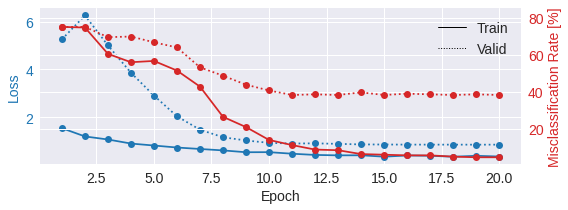

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
# Extract loss and accuracy values for plotting from history object
results_columns = ['train_loss', 'valid_loss', 'train_accuracy', 'valid_accuracy']
df = pd.DataFrame(clf.history[:, results_columns], columns=results_columns,
                  index=clf.history[:, 'epoch'])

# get percent of misclass for better visual comparison to loss
df = df.assign(train_misclass=100 - 100 * df.train_accuracy,
               valid_misclass=100 - 100 * df.valid_accuracy)

plt.style.use('seaborn')
fig, ax1 = plt.subplots(figsize=(8, 3))
df.loc[:, ['train_loss', 'valid_loss']].plot(
    ax=ax1, style=['-', ':'], marker='o', color='tab:blue', legend=False, fontsize=14)

ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.set_ylabel("Loss", color='tab:blue', fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df.loc[:, ['train_misclass', 'valid_misclass']].plot(
    ax=ax2, style=['-', ':'], marker='o', color='tab:red', legend=False)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
ax2.set_ylabel("Misclassification Rate [%]", color='tab:red', fontsize=14)
ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
ax1.set_xlabel("Epoch", fontsize=14)

# where some data has already been plotted to ax
handles = []
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Train'))
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle=':', label='Valid'))
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()

## Visualization with Amplitude Gradients

We now can try to understand the network a little bit better by computing gradients of the network class predictions on the per-frequency amplitudes of the input.

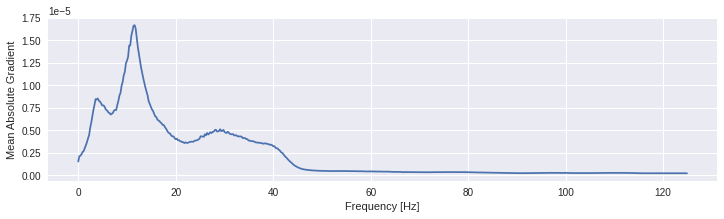

In [ ]:
from braindecode.visualization.gradients import compute_amplitude_gradients

amp_grads_per_filter = compute_amplitude_gradients(model, train_set, batch_size=64)

plt.figure(figsize=(12,3))
plt.plot(np.fft.rfftfreq(train_set[0][0].shape[1], 1/250.0), np.mean(np.abs(amp_grads_per_filter), axis=(0, 1,2)));
plt.xlabel('Frequency [Hz]')
plt.ylabel('Mean Absolute Gradient');

We can investigate the alpha band a bit more deeply.

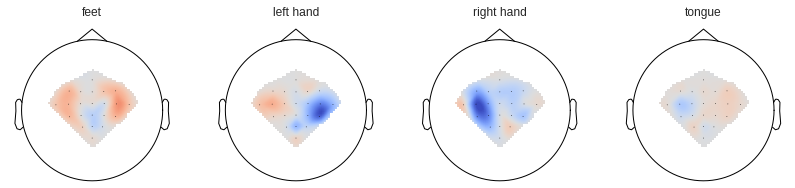

In [ ]:
sfreq = train_set.datasets[0].windows.info['sfreq']
freqs = np.fft.rfftfreq(train_set[0][0].shape[1], d=1.0/sfreq)
start_freq = 7
stop_freq = 14
i_start = np.searchsorted(freqs,start_freq)
i_stop = np.searchsorted(freqs, stop_freq) + 1


freq_corr = np.mean(np.mean(amp_grads_per_filter, axis=1)[:,:,i_start:i_stop], axis=2)

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
max_abs_val = np.max(np.abs(freq_corr))

class_to_id = windows_dataset.datasets[0].windows.event_id

fig, axes = plt.subplots(1, len(class_to_id), figsize=(14,4))
for class_name, i_class in class_to_id.items():
    ax = axes[i_class]
    mne.viz.plot_topomap(freq_corr[i_class], train_set.datasets[0].windows.info,
             vmin=-max_abs_val, vmax=max_abs_val, contours=0,
            cmap=cm.coolwarm, show=False, extrapolate='local',
                        axes=ax);
    ax.set_title(class_name.replace('_', ' '))

## Cropped Decoding

Now, we do more data-efficient cropped decoding!

In Braindecode, there are two supported configurations created for training models: trialwise decoding and cropped
decoding. We will explain this visually by comparing trialwise to cropped decoding.

![](https://braindecode.org/_images/trialwise_explanation.png)
![](https://braindecode.org/_images/cropped_explanation.png)


On the left, you see trialwise decoding:

1. A complete trial is pushed through the network.
2. The network produces a prediction.
3. The prediction is compared to the target (label) for that trial to compute the loss.

On the right, you see cropped decoding:

1. Instead of a complete trial, crops are pushed through the network.
2. For computational efficiency, multiple neighbouring crops are pushed through the network simultaneously (these
   neighbouring crops are called compute windows)
3. Therefore, the network produces multiple predictions (one per crop in the window)
4. The individual crop predictions are averaged before computing the loss function

## Create model and compute windowing parameters

We will use the deep4 model this time!

In contrast to trialwise computing, we first have to create the model before we can cut the dataset into windows. This is because we need to know the receptive field of the network to know how large the window stride should be.

We first choose the compute/input window size
that will be fed to the network during training
This has to be larger than the networks receptive field size
and can otherwise be chosen for computational efficiency (see explanations in the beginning of this tutorial). Here we choose 1000 samples, which are 4 seconds.

In [ ]:
input_window_samples = 1000

Now we create the model. To enable it to be used in cropped decoding efficiently, we manually set the length of the final convolution layer to some length that makes the receptive field of the ConvNet smaller than `input_window_samples` (see `final_conv_length=30` in the model definition).

In [ ]:
import torch
from braindecode.util import set_random_seeds
from braindecode.models import Deep4Net


cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
seed = 20200220  # random seed to make results reproducible
# Set random seed to be able to reproduce results
set_random_seeds(seed=seed, cuda=cuda)

n_classes=4
# Extract number of chans from dataset
n_chans = dataset[0][0].shape[0]

model = Deep4Net(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length=2,
)

# Send model to GPU
if cuda:
    model.cuda()


And now we transform model with strides to a model that outputs dense prediction, so we can use it to obtain properly predictions for all crops.

In [ ]:
from braindecode.models.util import to_dense_prediction_model, get_output_shape
to_dense_prediction_model(model)

To know the models' receptive field, we calculate the shape of model output for a dummy input.

In [ ]:
n_preds_per_input = get_output_shape(model, n_chans, input_window_samples)[2]

## Cut the data into windows

Now we have to supply an explicit window size and window stride to the `create_windows_from_events` function.

In [ ]:
import numpy as np
from braindecode.datautil.windowers import create_windows_from_events

trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info['sfreq']
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])

# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    window_size_samples=input_window_samples,
    window_stride_samples=n_preds_per_input,
    drop_last_window=False,
    preload=True,
)

## Split the dataset

This code is the same as in trialwise decoding.

In [ ]:
splitted = windows_dataset.split('session')
train_set = splitted['session_T']
valid_set = splitted['session_E']

## Training

In difference to trialwise decoding, we now should supply `cropped=True` to the EEGClassifier, and `CroppedLoss` as the criterion, as well as `criterion__loss_function` as the loss function applied to the meaned predictions.

> **Note**: In this tutorial, we use some default parameters that we have found to work well for
motor decoding, however we strongly encourage you to perform your own hyperparameter
optimization using cross validation on your training data.

In [ ]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier
from braindecode.training.losses import CroppedLoss

# These values we found good for shallow network:

# For deep4 they should be:
lr = 1 * 0.01
weight_decay = 0.5 * 0.001

batch_size = 64
n_epochs = 40

clf = EEGClassifier(
    model,
    cropped=True,
    criterion=CroppedLoss,
    criterion__loss_function=torch.nn.functional.nll_loss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set),
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    iterator_train__shuffle=True,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
clf.fit(train_set, y=None, epochs=n_epochs)

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  ----------------  ------------  ------
      1            0.2500        2.8734            0.2500       14.9372  1.7340


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2            0.2500        1.2863            0.2500        3.4283  1.6868
      3            0.2604        1.1481            0.2535        2.9051  1.6833
      4            0.3993        1.1220            0.4236        1.3055  1.6819
      5            0.6632        1.1157            0.5625        1.0367  1.6725
      6            0.6250        1.0892            0.5799        1.0508  1.6776
      7            0.5000        1.0390            0.4792        1.2397  1.6683
      8            0.6042        1.0328            0.5556        1.0871  1.6852
      9            0.5590        1.0104            0.5590        1.0910  1.6731
     10            0.5938        0.9451            0.5139        1.2314  1.6849
     11            0.6111        0.8701            0.5104        1.3839  1.6762
     12            0.6285        0.8919            0.4896        1.3075  1.6745
     13            0.6007        0.8179            0.5868        0.9915  1.6730
     14            0.5799        0.8459 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=Deep4Net(
    (ensuredims): Ensure4d()
    (dimshuffle): Expression(expression=transpose_time_to_spat) 
    (conv_time): Conv2d(1, 25, kernel_size=(10, 1), stride=(1, 1))
    (conv_spat): Conv2d(25, 25, kernel_size=(1, 22), stride=(1, 1), bias=False)
    (bnorm): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_nonlin): Expression(expression=elu) 
    (pool): MaxPool2d(kernel_size=(3, 1), stride=(1, 1), padding=0, dilation=(1, 1), ceil_mode=False)
    (pool_nonlin): Expression(expression=identity) 
    (drop_2): Dropout(p=0.5, inplace=False)
    (conv_2): Conv2d(25, 50, kernel_size=(10, 1), stride=(1, 1), dilation=(3, 1), bias=False)
    (bnorm_2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (nonlin_2): Expression(expression=elu) 
    (pool_2): MaxPool2d(kernel_size=(3, 1), stride=(1, 1), padding=0, dilation=(3, 1), ceil_mode=False)
   

In [ ]:
from braindecode.visualization.gradients import compute_amplitude_gradients

amp_grads_per_filter = compute_amplitude_gradients(model, train_set, batch_size=64)

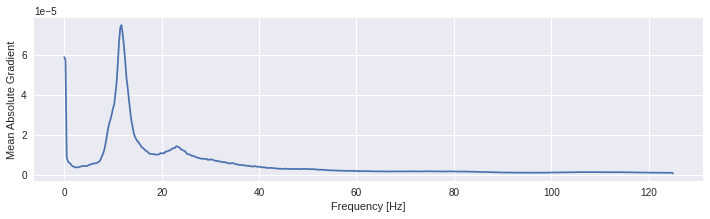

In [ ]:
plt.figure(figsize=(12,3))
plt.plot(np.fft.rfftfreq(train_set[0][0].shape[1], 1/250.0), np.mean(np.abs(amp_grads_per_filter), axis=(0, 1,2)));
plt.xlabel('Frequency [Hz]')
plt.ylabel('Mean Absolute Gradient');

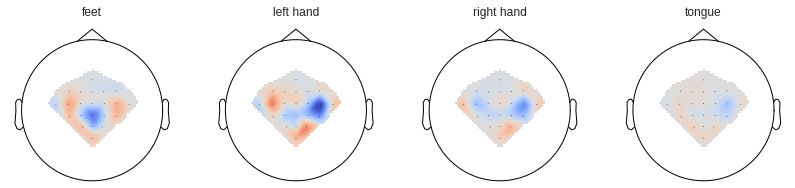

In [ ]:
sfreq = train_set.datasets[0].windows.info['sfreq']
freqs = np.fft.rfftfreq(train_set[0][0].shape[1], d=1.0/sfreq)
start_freq = 7
stop_freq = 14
i_start = np.searchsorted(freqs,start_freq)
i_stop = np.searchsorted(freqs, stop_freq) + 1


freq_corr = np.mean(np.mean(amp_grads_per_filter, axis=1)[:,:,i_start:i_stop], axis=2)

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
max_abs_val = np.max(np.abs(freq_corr))

class_to_id = windows_dataset.datasets[0].windows.event_id

fig, axes = plt.subplots(1, len(class_to_id), figsize=(14,4))
for class_name, i_class in class_to_id.items():
    ax = axes[i_class]
    mne.viz.plot_topomap(freq_corr[i_class], train_set.datasets[0].windows.info,
             vmin=-max_abs_val, vmax=max_abs_val, contours=0,
            cmap=cm.coolwarm, show=False, extrapolate='local',
                        axes=ax);
    ax.set_title(class_name.replace('_', ' '))

## Redo without -500ms before trial

In [ ]:
import torch
from braindecode.util import set_random_seeds
from braindecode.models import Deep4Net


cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
seed = 20200220  # random seed to make results reproducible
# Set random seed to be able to reproduce results
set_random_seeds(seed=seed, cuda=cuda)

n_classes=4
# Extract number of chans from dataset
n_chans = dataset[0][0].shape[0]

model = Deep4Net(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length=2,
)

# Send model to GPU
if cuda:
    model.cuda()


from braindecode.models.util import to_dense_prediction_model, get_output_shape

n_preds_per_input = get_output_shape(model, n_chans, input_window_samples)[2]
to_dense_prediction_model(model)

In [ ]:
import numpy as np
from braindecode.datautil.windowers import create_windows_from_events

trial_start_offset_seconds = -0
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info['sfreq']
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])

# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    window_size_samples=input_window_samples,
    window_stride_samples=n_preds_per_input,
    drop_last_window=False,
    preload=True,
)

In [ ]:
splitted = windows_dataset.split('session')
train_set = splitted['session_T']
valid_set = splitted['session_E']

In [ ]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier
from braindecode.training.losses import CroppedLoss

# These values we found good for shallow network:

# For deep4 they should be:
lr = 1 * 0.01
weight_decay = 0.5 * 0.001

batch_size = 64
n_epochs = 50

clf = EEGClassifier(
    model,
    cropped=True,
    criterion=CroppedLoss,
    criterion__loss_function=torch.nn.functional.nll_loss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set),
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    iterator_train__shuffle=True,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
clf.fit(train_set, y=None, epochs=n_epochs)

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  ----------------  ------------  ------
      1            0.2500        4.3938            0.2500       87.0039  1.7246


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2            0.2500        2.0783            0.2500       13.9299  0.8539
      3            0.2569        1.5082            0.2535       17.5981  0.8514
      4            0.2500        1.3458            0.2500        6.8067  0.8526
      5            0.2500        1.3003            0.2500        4.8182  0.8528
      6            0.3785        1.2004            0.3576        1.7005  0.8489
      7            0.5312        1.1349            0.4826        1.1624  0.8413
      8            0.5243        1.1525            0.5174        1.1153  0.8581
      9            0.4931        1.0868            0.5000        1.2906  0.8520
     10            0.5590        1.1051            0.5486        1.0689  0.8533
     11            0.5625        1.0772            0.5312        1.0864  0.8485
     12            0.5278        1.0826            0.5278        1.1055  0.8552
     13            0.4861        1.0827            0.5069        1.1337  0.8461
     14            0.5486        1.0421 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=Deep4Net(
    (ensuredims): Ensure4d()
    (dimshuffle): Expression(expression=transpose_time_to_spat) 
    (conv_time): Conv2d(1, 25, kernel_size=(10, 1), stride=(1, 1))
    (conv_spat): Conv2d(25, 25, kernel_size=(1, 22), stride=(1, 1), bias=False)
    (bnorm): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_nonlin): Expression(expression=elu) 
    (pool): MaxPool2d(kernel_size=(3, 1), stride=(1, 1), padding=0, dilation=(1, 1), ceil_mode=False)
    (pool_nonlin): Expression(expression=identity) 
    (drop_2): Dropout(p=0.5, inplace=False)
    (conv_2): Conv2d(25, 50, kernel_size=(10, 1), stride=(1, 1), dilation=(3, 1), bias=False)
    (bnorm_2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (nonlin_2): Expression(expression=elu) 
    (pool_2): MaxPool2d(kernel_size=(3, 1), stride=(1, 1), padding=0, dilation=(3, 1), ceil_mode=False)
   

In [ ]:
from braindecode.visualization.gradients import compute_amplitude_gradients

amp_grads_per_filter = compute_amplitude_gradients(model, train_set, batch_size=64)

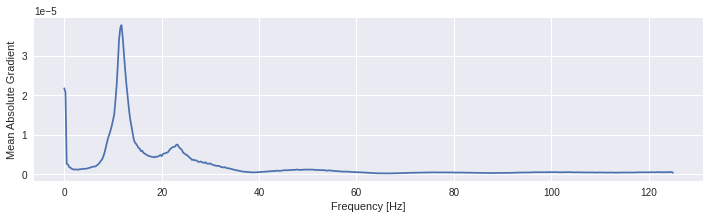

In [ ]:
plt.figure(figsize=(12,3))
plt.plot(np.fft.rfftfreq(train_set[0][0].shape[1], 1/250.0), np.mean(np.abs(amp_grads_per_filter), axis=(0, 1,2)));
plt.xlabel('Frequency [Hz]')
plt.ylabel('Mean Absolute Gradient');

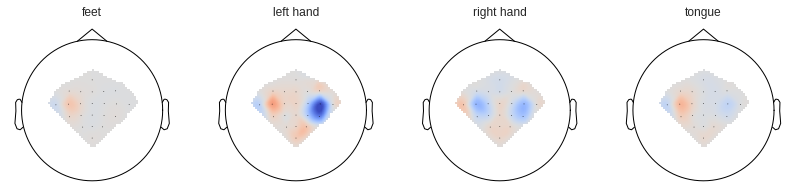

In [ ]:
sfreq = train_set.datasets[0].windows.info['sfreq']
freqs = np.fft.rfftfreq(train_set[0][0].shape[1], d=1.0/sfreq)
start_freq = 7
stop_freq = 14
i_start = np.searchsorted(freqs,start_freq)
i_stop = np.searchsorted(freqs, stop_freq) + 1


freq_corr = np.mean(np.mean(amp_grads_per_filter, axis=1)[:,:,i_start:i_stop], axis=2)

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
max_abs_val = np.max(np.abs(freq_corr))

class_to_id = windows_dataset.datasets[0].windows.event_id

fig, axes = plt.subplots(1, len(class_to_id), figsize=(14,4))
for class_name, i_class in class_to_id.items():
    ax = axes[i_class]
    mne.viz.plot_topomap(freq_corr[i_class], train_set.datasets[0].windows.info,
             vmin=-max_abs_val, vmax=max_abs_val, contours=0,
            cmap=cm.coolwarm, show=False, extrapolate='local',
                        axes=ax);
    ax.set_title(class_name.replace('_', ' '))

See more on https://braindecode.org